# Decision Trees

In [1]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funciones_mecanizados import cortar

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from pydotplus import graph_from_dot_data
import pydotplus
import graphviz 
from sklearn import tree

In [2]:
# Cargamos el dataset preprocesado.
h1_norm = pd.read_csv('data/panel1_H1_norm.csv')
h2_norm = pd.read_csv('data/panel2_H2_norm.csv')
h3_norm = pd.read_csv('data/panel1_H3_norm.csv')



columnas = ['P_FRQ', 'RISE', 'COUN', 'ENER', 'DURATION', 'AMP', 'A_FRQ', 'RMS',
       'ASL', 'PCNTS', 'R_FRQ', 'I_FRQ', 'SIG_STRNGTH', 'ABS_ENERGY', 'C_FRQ', 'P_MARSE']



#Elminamos el ruido
nivel_filtro = 0.0
data = [h1_norm, h2_norm,h3_norm]
for dat in data:
    dat.drop(dat[dat['ENER']<nivel_filtro].index, axis=0, inplace=True)


mecanizados = pd.concat([h1_norm, h2_norm, h3_norm])
mecanizados.reset_index(drop=True, inplace=True)

#Nos quedamos con algunos datos del fresado
#corte1 = [0,2]
#corte2 = [2,4]

#fresado_h1 = pd.concat([cortar(h1_norm, corte1), cortar(h1_norm, corte2)])
#fresado_h2 = pd.concat([cortar(h2_norm, corte1), cortar(h2_norm, corte2)])
#fresado_h3 = pd.concat([cortar(h3_norm, corte1), cortar(h3_norm, corte2)])

#print('H1:',fresado_h1.shape)
#print('H2:',fresado_h2.shape)
#print('H3:',fresado_h3.shape)

In [3]:
#Juntamos todos los datos en un solo DF
#fresado = pd.concat([fresado_h1, fresado_h2, fresado_h3])

### Train/Test split

In [4]:
#Dividimos el dataset en datos de entrenamiento y de prueba. Usamos StratifiedShufflesSplir 
#para mantener la proporción de las clases objetivo.

from sklearn.model_selection import StratifiedShuffleSplit

train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=11)
for train_index, test_index in train_test_split.split(mecanizados, mecanizados['Herramienta']):
    train = mecanizados.iloc[train_index]
    test = mecanizados.iloc[test_index]

In [5]:
# Cantidad de datos por partición
print('Datos totales:',mecanizados.shape[0])
print('Train:        ',train.shape[0])
print('Test:         ',test.shape[0])

Datos totales: 9014
Train:         7211
Test:          1803


In [6]:
train['Herramienta'].value_counts()

H1    2486
H3    2397
H2    2328
Name: Herramienta, dtype: int64

In [7]:

test['Herramienta'].value_counts()

H1    622
H3    599
H2    582
Name: Herramienta, dtype: int64

In [8]:
#Datos para la validación cruzada
#Hacemos una copia y eliminamos las variables que no vamos a usar.

X = train.copy()
y = X.pop('Herramienta')

X.drop(['CH','Tiempo', 'Mecanizado'], axis=1, inplace=True)

In [9]:
#Datos para entrenar y probar el modelo.
y_train = train.Herramienta
y_test = test.Herramienta

X_train = train[columnas]
X_test = test[columnas]

## Modelos

### Simple sin ajustes

In [10]:
#Modelo Decisión Tree
clf_ = DecisionTreeClassifier(random_state = 14)
clf_.fit(X_train, y_train)

prediccion_ = clf_.predict(X_test)

score_ = round(accuracy_score(y_test, prediccion_),4)
print('################# Puntuación ##################')
print('###################',score_,'####################')

#Matriz de confusión
conf_matrix = confusion_matrix(y_test, prediccion_,labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_test, prediccion_))

################# Puntuación ##################
################### 0.8697 ####################
    H1_predicción  H2_predicción  H3_predicción
H1            546             32             44
H2             41            498             43
H3             35             40            524


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       0.88      0.88      0.88       622
          H2       0.87      0.86      0.86       582
          H3       0.86      0.87      0.87       599

    accuracy                           0.87      1803
   macro avg       0.87      0.87      0.87      1803
weighted avg       0.87      0.87      0.87      1803



In [11]:
'''dot_data =tree.export_graphviz(
clf_,
feature_names=columnas,
class_names= ['Muy Usada', 'Usada', 'Nueva'], 
rounded=True,
filled=True
)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree_simple.png')
pydot_graph.set_size('"15,15!"')

gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph'''

'dot_data =tree.export_graphviz(\nclf_,\nfeature_names=columnas,\nclass_names= [\'Muy Usada\', \'Usada\', \'Nueva\'], \nrounded=True,\nfilled=True\n)\n\npydot_graph = pydotplus.graph_from_dot_data(dot_data)\npydot_graph.write_png(\'tree_simple.png\')\npydot_graph.set_size(\'"15,15!"\')\n\ngvz_graph = graphviz.Source(pydot_graph.to_string())\ngvz_graph'

### Ajuste de los Hiperparámetros

In [12]:
#Valores de los Hiperparámetros a probar.
grilla_parametros =  {'max_features': [5, 7, 9, 12, 15,16],
                      'max_depth'   : [5,6,7,8,9,10],
                      'criterion'   : ['gini', 'entropy'],
                      'min_samples_leaf' :[5,6,7,8],
                      'min_samples_split': [5,10,15,20]
                     }

#Usamos Stratified para la validación cruzada
kf= StratifiedShuffleSplit(n_splits=5, test_size=.20, random_state=11)

#Modelo Decisión Tree
clf = DecisionTreeClassifier(random_state = 14)

#Ajuste
clasificador = GridSearchCV(clf,
                            param_grid=grilla_parametros, 
                            cv=kf,
                            verbose=2, 
                            n_jobs=2
                           )
clasificador.fit(X_train, y_train)


print(clasificador.best_params_)

print('################# Puntuación ##################')
print('###################',round(clasificador.best_score_,4),'####################')


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  56 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 540 tasks      | elapsed:   23.7s
[Parallel(n_jobs=2)]: Done 1352 tasks      | elapsed:   51.8s
[Parallel(n_jobs=2)]: Done 2484 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 3944 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 5406 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 5757 out of 5760 | elapsed:  4.9min remaining:    0.1s
[Parallel(n_jobs=2)]: Done 5760 out of 5760 | elapsed:  4.9min finished


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 5, 'min_samples_split': 15}
################# Puntuación ##################
################### 0.8378 ####################


### Entrenamiento del modelo

In [13]:
#Modelo con los hiperparámetros ajustados
tree_model = DecisionTreeClassifier(max_features=clasificador.best_params_['max_features'], 
                                    criterion=clasificador.best_params_['criterion'], 
                                    max_depth=clasificador.best_params_['max_depth'],
                                    min_samples_leaf=clasificador.best_params_['min_samples_leaf'],
                                    min_samples_split=clasificador.best_params_['min_samples_split'],
                                    random_state = 14)
tree_model.fit(X_train, y_train)
prediccion = tree_model.predict(X_test)

score_ = round(accuracy_score(y_test, prediccion),4)
print('################# Puntuación ##################')
print('###################',score_,'####################')

print('')
print('###############################################')
print('########### Matriz de Confusión ###############')
print('###############################################')
print('')

#Matriz de confusión
conf_matrix = confusion_matrix(y_test, prediccion, labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_test, prediccion))

################# Puntuación ##################
################### 0.8414 ####################

###############################################
########### Matriz de Confusión ###############
###############################################

    H1_predicción  H2_predicción  H3_predicción
H1            518             36             68
H2             45            475             62
H3             26             49            524


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       0.88      0.83      0.86       622
          H2       0.85      0.82      0.83       582
          H3       0.80      0.87      0.84       599

    accuracy                           0.84      1803
   macro avg       0.84      0.84      0.84      1803
weighted avg       0.84      0.84      0.84      1803



#### Visualización del arbol

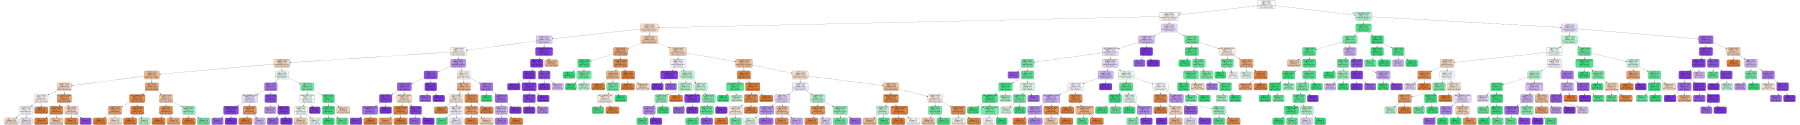

In [14]:
dot_data =tree.export_graphviz(
tree_model,
feature_names=columnas,
class_names= ['Muy Usada', 'Usada', 'Nueva'], 
rounded=True,
filled=True
)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree_sinpoda.png')
pydot_graph.set_size('"25,35!"')

gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

### Proceso de poda

Eliminamos los nodos de decisión cuya ramificación hace decrecer muy poco la impureza del subconjunto de datos. 
Se utiliza el hiperparámetro "min_impurity_decrease". El valor se eligió de tal forma que no haya una reducción significativa de la puntuación.

In [15]:
#Modelo final
tree_model_p = DecisionTreeClassifier(max_features=clasificador.best_params_['max_features'], 
                                    criterion=clasificador.best_params_['criterion'], 
                                    max_depth=clasificador.best_params_['max_depth'],
                                    min_samples_leaf=clasificador.best_params_['min_samples_leaf'],
                                    min_samples_split=clasificador.best_params_['min_samples_split'],
                                    min_impurity_decrease=0.004,
                                    random_state = 14)
tree_model_p.fit(X_train, y_train)
prediccion = tree_model_p.predict(X_test)
score = round(accuracy_score(y_test, prediccion),4)
print('################# Puntuación ##################')
print('###################',score,'####################')


print('')
print('###############################################')
print('########### Matriz de Confusión ###############')
print('###############################################')
print('')

#Matriz de confusión
conf_matrix = confusion_matrix(y_test, prediccion, labels=['H1','H2','H3'])
print(pd.DataFrame(data=conf_matrix, index=['H1','H2','H3'], columns=['H1_predicción','H2_predicción','H3_predicción']))

print('')
print('')
print('#####################################################')
print('##################### Scores ########################')
print('#####################################################')
print('')

#Scores
print (classification_report(y_test, prediccion))

################# Puntuación ##################
################### 0.8026 ####################

###############################################
########### Matriz de Confusión ###############
###############################################

    H1_predicción  H2_predicción  H3_predicción
H1            496             59             67
H2             54            471             57
H3             50             69            480


#####################################################
##################### Scores ########################
#####################################################

              precision    recall  f1-score   support

          H1       0.83      0.80      0.81       622
          H2       0.79      0.81      0.80       582
          H3       0.79      0.80      0.80       599

    accuracy                           0.80      1803
   macro avg       0.80      0.80      0.80      1803
weighted avg       0.80      0.80      0.80      1803



#### Visualización del arbol podado.

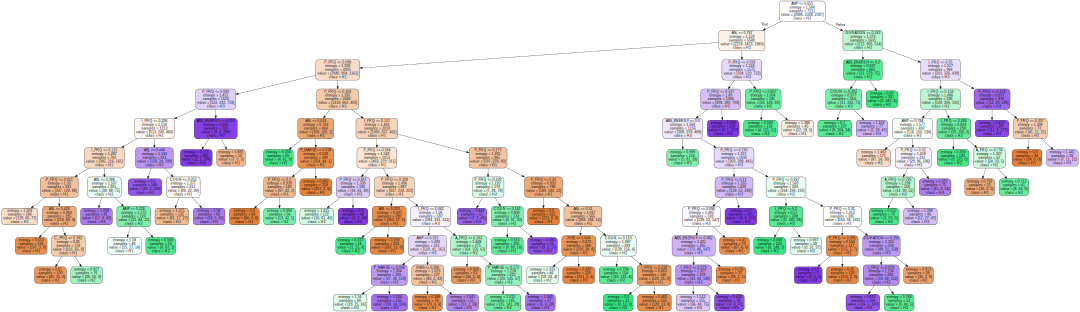

In [16]:
dot_data =tree.export_graphviz(
tree_model_p,
feature_names=columnas,
class_names= ['H1', 'H2', 'H3'], 
rounded=True,
filled=True
)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree_poda.png')
pydot_graph.set_size('"15,15!"')

gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

Puntaje de los parámetros:
1. Parámetro 0 (0.450932)
2. Parámetro 11 (0.156693)
3. Parámetro 8 (0.108200)
4. Parámetro 5 (0.089585)
5. Parámetro 4 (0.061406)
6. Parámetro 2 (0.035621)
7. Parámetro 13 (0.034367)
8. Parámetro 6 (0.023465)
9. Parámetro 15 (0.019911)
10. Parámetro 1 (0.007948)
11. Parámetro 7 (0.006714)
12. Parámetro 14 (0.005158)
13. Parámetro 12 (0.000000)
14. Parámetro 10 (0.000000)
15. Parámetro 9 (0.000000)
16. Parámetro 3 (0.000000)


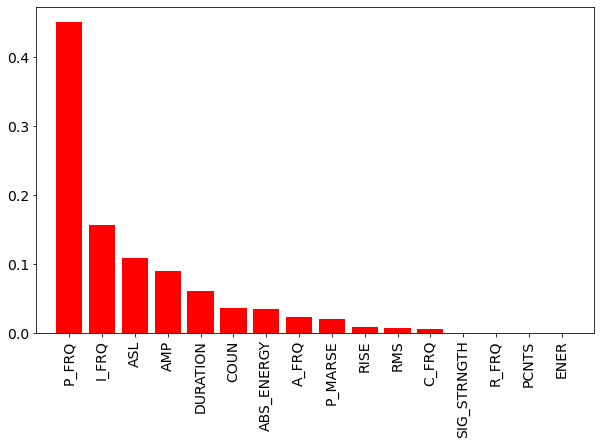

In [17]:
importances = tree_model_p.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Puntaje de los parámetros:")

for f in range(X.shape[1]-1):
    print("%d. Parámetro %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,6))
plt.bar(X.columns[indices], importances[indices], color="r", align="center")
plt.xticks(X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]-1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()